https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/

# Imports

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [3]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from IPython.display import display

In [4]:
PATH = 'data/nyc-taxi/'

# Load training and test data

The entire dataset has about 55,423,857 rows

In [5]:
types = {'fare_amount': 'float32',
         'pickup_longitude': 'float32',
         'pickup_latitude': 'float32',
         'dropoff_longitude': 'float32',
         'dropoff_latitude': 'float32',
         'passenger_count': 'uint8'}

# Columns to keep (basically discarding the 'key' column) - thanks to the suggestion by mhviraf
cols_train = ['fare_amount', 'pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

# No 'fare_amount'
cols_test = ['pickup_datetime', 'pickup_longitude', 
        'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

In [6]:
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. Or try 10 million
total_chunk = 55423857 // chunksize + 1

print(f'Chunk size: {chunksize:,}\nTotal chunks required: {total_chunk}')

Chunk size: 10,000,000
Total chunks required: 6


In [7]:
%%time
i=0
for df_chunk in pd.read_csv(f'{PATH}train.csv', parse_dates=["pickup_datetime"], usecols=cols_train,
                         infer_datetime_format=True, dtype=types, chunksize=chunksize):
    
    i = i+1
    # Each chunk is a corresponding dataframe
    print(f'DataFrame Chunk {i}/{total_chunk}')
    
    # Can process each chunk of dataframe here
    # feature_engineer(), remove_outliers(), fit(), predict()
    
    # Alternatively, append the chunk to list and merge all
    df_list.append(df_chunk) 

DataFrame Chunk 1/6
DataFrame Chunk 2/6
DataFrame Chunk 3/6
DataFrame Chunk 4/6
DataFrame Chunk 5/6
DataFrame Chunk 6/6
Wall time: 4min 31s


In [8]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

In [9]:
del df_list

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 7 columns):
fare_amount          float32
pickup_datetime      datetime64[ns]
pickup_longitude     float32
pickup_latitude      float32
dropoff_longitude    float32
dropoff_latitude     float32
passenger_count      uint8
dtypes: datetime64[ns](1), float32(5), uint8(1)
memory usage: 1.5 GB


In [11]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [12]:
%%time
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-raw')

Wall time: 5.78 s


In [7]:
%%time
train_df = pd.read_feather('tmp/taxi-train-raw')

Wall time: 7.26 s


In [8]:
test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)

# Quick EDA

In [9]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844315,40.721317,-73.841614,40.712276,1
1,16.9,2010-01-05 16:52:16,-74.016045,40.711304,-73.979271,40.782005,1
2,5.7,2011-08-18 00:35:00,-73.982735,40.761269,-73.991241,40.750561,2
3,7.7,2012-04-21 04:30:42,-73.987129,40.733143,-73.991570,40.758091,1
4,5.3,2010-03-09 07:51:00,-73.968094,40.768009,-73.956657,40.783764,1


,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
55423851,14.0,2014-03-15 03:28:00,-74.005272,40.740028,-73.963280,40.762554,1
55423852,4.2,2009-03-24 20:46:20,-73.957787,40.765530,-73.951637,40.773960,1
55423853,14.1,2011-04-02 22:04:24,-73.970505,40.752323,-73.960541,40.797340,1
55423854,28.9,2011-10-26 05:57:51,-73.980904,40.764629,-73.870605,40.773964,1
55423855,7.5,2014-12-12 11:33:00,-73.969719,40.797668,-73.970886,40.783314,1


In [10]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44,-73.982521,40.751259,-73.979652,40.746140,1
3,2012-12-01 21:12:12,-73.981163,40.767807,-73.990448,40.751637,1
4,2012-12-01 21:12:12,-73.966049,40.789776,-73.988564,40.744427,1


,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
9909,2015-05-10 12:37:51,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19,-73.985573,40.735432,-73.939178,40.801731,6
9913,2015-01-18 14:06:23,-73.988022,40.754070,-74.000282,40.759220,6


In [11]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.54239e+07,NaN,5.54239e+07,5.54239e+07,5.54235e+07,5.54235e+07,5.54239e+07
mean,11.345,NaN,-72.5097,39.9198,-72.5111,39.9207,1.68538
std,20.7108,NaN,12.8489,9.64235,12.7822,9.63335,1.32766
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208
counts,55423856,55423856,55423856,55423856,55423480,55423480,55423856
uniques,9405,26173536,98330,116546,114629,134778,15


In [12]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,NaN,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875
min,NaN,-74.2522,40.5731,-74.2632,40.569,1
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2
max,NaN,-72.9865,41.7096,-72.991,41.6967,6
counts,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6


# Remove missing values

In [13]:
train_df.isnull().sum() 

fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [14]:
test_df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [15]:
print('Old size: %d' % len(train_df))
train_df = train_df.dropna(how = 'any', axis = 'rows')
print('New size: %d' % len(train_df))

Old size: 55423856
New size: 55423480


# Travel vector longitude, latitude and simple distance

In [16]:
def add_travel_vector_features(df):
    df['abs_diff_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['abs_diff_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

In [17]:
def add_simple_distance(df):
    df['simple_distance'] = np.sqrt(df.abs_diff_longitude ** 2 + df.abs_diff_latitude ** 2)

In [18]:
add_travel_vector_features(train_df)
add_simple_distance(train_df)

In [19]:
add_travel_vector_features(test_df)
add_simple_distance(test_df)

In [20]:
DataFrameSummary(train_df).summary()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,5.54235e+07,NaN,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07,5.54235e+07
mean,11.345,NaN,-72.5099,39.9198,-72.5112,39.9207,1.68539,0.199236,0.122812,0.252637
std,20.7109,NaN,12.8488,9.64232,12.7822,9.63335,1.32766,9.44166,9.40297,13.3249
min,-300,NaN,-3442.06,-3492.26,-3442.02,-3547.89,0,0,0,0
25%,6,NaN,-73.9921,40.7349,-73.9914,40.734,1,0.00580597,0.00658417,0.0123897
50%,8.5,NaN,-73.9818,40.7527,-73.9801,40.7532,1,0.0124359,0.0138588,0.0214342
75%,12.5,NaN,-73.9671,40.7671,-73.9637,40.7681,2,0.0237122,0.0269356,0.0383414
max,93963.4,NaN,3457.63,3408.79,3457.62,3537.13,208,6812.94,6818.56,8039.08
counts,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480,55423480
uniques,9391,26173267,98330,116546,114629,134778,15,91903,117299,16973659


In [21]:
DataFrameSummary(test_df).summary()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,NaN,9914,9914,9914,9914,9914,9914,9914,9914
mean,NaN,-73.9747,40.751,-73.9737,40.7517,1.67127,0.0233484,0.0221326,0.0351464
std,NaN,0.042774,0.0335415,0.0390719,0.0354352,1.27875,0.0367193,0.0255887,0.0424594
min,NaN,-74.2522,40.5731,-74.2632,40.569,1,0,0,0
25%,NaN,-73.9925,40.7361,-73.9912,40.7353,1,0.00635529,0.00727844,0.013261
50%,NaN,-73.9823,40.7531,-73.98,40.7541,1,0.0131226,0.0147152,0.0224233
75%,NaN,-73.968,40.7671,-73.9641,40.7688,2,0.0245628,0.0282612,0.0401673
max,NaN,-72.9865,41.7096,-72.991,41.6967,6,0.849174,0.633213,1.05733
counts,9914,9914,9914,9914,9914,9914,9914,9914,9914
uniques,1753,5894,7857,6174,8124,6,4896,6761,9820


## Range of min and max longitude and latitude values from test set

The latitude of New York City, NY, USA is **40.730610**, and the longitude is **-73.935242**. 

In [22]:
plongmin, plongmax = test_df.pickup_longitude.min(),test_df.pickup_longitude.max()
plongmin, plongmax

(-74.25219, -72.986534)

In [23]:
dlongmin, dlongmax = test_df.dropoff_longitude.min(),test_df.dropoff_longitude.max()
dlongmin, dlongmax

(-74.263245, -72.99097)

In [24]:
platmin, platmax = test_df.pickup_latitude.min(),test_df.pickup_latitude.max()
platmin, platmax 

(40.573143, 41.709557)

In [25]:
dlatmin, dlatmax = test_df.dropoff_latitude.min(),test_df.dropoff_latitude.max()
dlatmin, dlatmax

(40.568974, 41.696682)

In [26]:
len(train_df[(train_df.pickup_longitude < plongmin) | (train_df.pickup_longitude > plongmax)])

1108744

In [27]:
len(train_df[(train_df.dropoff_longitude < dlongmin ) | (train_df.dropoff_longitude > dlongmax)])

1104873

In [28]:
len(train_df[(train_df.pickup_latitude < platmin) | (train_df.pickup_latitude > platmax)])

1104470

In [29]:
len(train_df[(train_df.dropoff_latitude < dlatmin ) | (train_df.dropoff_latitude > dlatmax)])

1105212

In [30]:
len(train_df[(train_df.pickup_longitude < plongmin) | (train_df.pickup_longitude > plongmax) |
             (train_df.dropoff_longitude < dlongmin) | (train_df.dropoff_longitude > dlongmax) |
             (train_df.pickup_latitude < platmin) | (train_df.pickup_latitude > platmax) |
             (train_df.dropoff_latitude < dlatmin) | (train_df.dropoff_latitude > dlatmax)])

1186729

In [31]:
delta_long = 0
delta_lat = 0

In [32]:
a = len(train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)])
a

54236751

Each degree of latitude is approximately 69 miles (111 kilometers) apart.

In [33]:
# tweakable
delta_long = 0.5 
delta_lat = 0.5

In [34]:
b = len(train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)])
b

54256759

In [35]:
b-a

20008

In [36]:
print('Old size: %d' % len(train_df))

Old size: 55423480


In [37]:
train_df = train_df[  
    (train_df.pickup_longitude >= plongmin - delta_long) & (train_df.pickup_longitude <= plongmax + delta_long) &
    (train_df.dropoff_longitude >= dlongmin - delta_long) & (train_df.dropoff_longitude <= dlongmax + delta_long) &
    (train_df.pickup_latitude >= platmin - delta_lat) & (train_df.pickup_latitude <= platmax + delta_lat) &
    (train_df.dropoff_latitude >= dlatmin - delta_lat) & (train_df.dropoff_latitude <= dlatmax + delta_lat)]

In [38]:
print('New size: %d' % len(train_df))

New size: 54256759


In [78]:
print('Removed {:,} rows'.format(55423480 - 54256759))

Removed 1,166,721 rows


## Checkpoint 1

In [40]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [41]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt1')

Wall time: 7.62 s


In [42]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt1')

Wall time: 11.4 ms


In [43]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt1')

Wall time: 2.34 s


In [44]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt1')

Wall time: 1.98 ms


## Distance

In [45]:
test_df.simple_distance.min(), test_df.abs_diff_latitude.min(),  test_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [46]:
# zero travel distance - cancellation? minimum payment such as booking fee?

(len(test_df[test_df.simple_distance == 0]), 
len(test_df[test_df.abs_diff_latitude == 0]),
len(test_df[test_df.abs_diff_longitude == 0]))

(85, 85, 87)

In [47]:
train_df.simple_distance.min(), train_df.abs_diff_latitude.min(), train_df.abs_diff_longitude.min()

(0.0, 0.0, 0.0)

In [48]:
(len(train_df[train_df.simple_distance == 0]), 
len(train_df[train_df.abs_diff_latitude == 0]),
len(train_df[train_df.abs_diff_longitude == 0]))

(586165, 602366, 616245)

In [49]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,586165.000000,586165.000000,586165.000000,586165.000000,586165.000000,586165.000000,586165.0,586165.0,586165.0
mean,11.302788,-73.945702,40.759102,-73.945702,40.759102,1.665809,0.0,0.0,0.0
std,16.195183,0.143397,0.105688,0.143397,0.105688,1.325243,0.0,0.0,0.0
min,-100.000000,-74.751770,40.104294,-74.751770,40.104294,0.000000,0.0,0.0,0.0
25%,4.900000,-73.990814,40.733528,-73.990814,40.733528,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975784,40.752193,-73.975784,40.752193,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948120,40.767773,-73.948120,40.767773,2.000000,0.0,0.0,0.0
max,3130.300049,-72.536484,42.142391,-72.536484,42.142391,208.000000,0.0,0.0,0.0


In [50]:
test_df.simple_distance.max(), test_df.abs_diff_latitude.max(), test_df.abs_diff_longitude.max()

(1.0573337, 0.63321304, 0.8491745)

In [51]:
train_df.simple_distance.max(), train_df.abs_diff_latitude.max(), train_df.abs_diff_longitude.max()

(1.6779635, 1.4938545, 1.6516495)

In [52]:
len(train_df[(train_df.abs_diff_latitude>test_df.abs_diff_latitude.max())])

2313

In [53]:
len(train_df[(train_df.abs_diff_longitude>test_df.abs_diff_longitude.max())])

2568

In [54]:
len(train_df[(train_df.simple_distance>test_df.simple_distance.max())])

2040

In [55]:
print('Old size: %d' % len(train_df))

Old size: 54256759


In [56]:
train_df = train_df[(train_df.abs_diff_latitude<=test_df.abs_diff_latitude.max()+delta_lat)]

In [57]:
print('New size: %d' % len(train_df))

New size: 54256732


In [58]:
train_df = train_df[(train_df.abs_diff_longitude<=test_df.abs_diff_longitude.max()+delta_long)]

In [59]:
print('New size: %d' % len(train_df))

New size: 54256716


In [60]:
# tweakable
train_df = train_df[(train_df.simple_distance<=test_df.simple_distance.max()+0.5)]

In [61]:
print('New size: %d' % len(train_df))

New size: 54256714


# Passenger Count

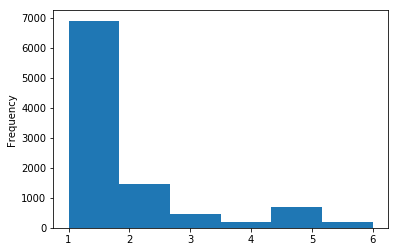

In [62]:
test_df.passenger_count.plot(kind='hist',bins=6)

In [63]:
test_df.passenger_count.value_counts()

1    6914
2    1474
5     696
3     447
4     206
6     177
Name: passenger_count, dtype: int64

In [64]:
train_df.passenger_count.value_counts().sort_index()

0        190842
1      37520717
2       8013836
3       2383325
4       1155673
5       3841986
6       1150270
7            13
8             7
9            21
129           2
208          22
Name: passenger_count, dtype: int64

In [65]:
# number rows with passenger = 0 or more than 6
len(train_df[(train_df.passenger_count == 0) | (train_df.passenger_count > 6)])

190907

In [66]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.passenger_count > 0) & (train_df.passenger_count < 7)]
print('New size: %d' % len(train_df))

Old size: 54256714
New size: 54065807


## Checkpoint 2

In [79]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [80]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt2')

Wall time: 7.68 s


In [81]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt2')

Wall time: 13.4 ms


In [177]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt2')

Wall time: 1.81 s


In [178]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt2')

Wall time: 2.5 ms


# Fare Amount

In [179]:
train_df.fare_amount.median(), train_df.fare_amount.mean()

(8.5, 11.333704)

In [180]:
train_df.fare_amount.quantile(0.99), train_df.fare_amount.quantile(0.999),train_df.fare_amount.quantile(0.99999)

(52.150001525878906, 78.7738774720383, 250.0)

In [181]:
len(train_df[(train_df.fare_amount==0)]) # those who paid nothing

1119

In [182]:
len(train_df[(train_df.fare_amount<0)])  # those who had refund?

2206

In [183]:
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99))])

540655

In [184]:
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.999))])

54066

In [185]:
len(train_df[(train_df.fare_amount>train_df.fare_amount.quantile(0.99999))])

488

In [186]:
fare_amount_threshold = 200

In [187]:
print('Old size: %d' % len(train_df))
train_df = train_df[(train_df.fare_amount>0) & (train_df.fare_amount<fare_amount_threshold)] # tweakable
print('New size: %d' % len(train_df))

Old size: 54065807
New size: 54060982


In [188]:
# check fare_amount for zero travel distance from training data
train_df[train_df.simple_distance == 0].describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_diff_longitude,abs_diff_latitude,simple_distance
count,585055.000000,585055.000000,585055.000000,585055.000000,585055.000000,585055.000000,585055.0,585055.0,585055.0
mean,11.173031,-73.945747,40.759087,-73.945747,40.759087,1.667247,0.0,0.0,0.0
std,14.301552,0.143125,0.105609,0.143125,0.105609,1.297408,0.0,0.0,0.0
min,0.010000,-74.751770,40.104294,-74.751770,40.104294,1.000000,0.0,0.0,0.0
25%,4.900000,-73.990807,40.733543,-73.990807,40.733543,1.000000,0.0,0.0,0.0
50%,6.900000,-73.975800,40.752193,-73.975800,40.752193,1.000000,0.0,0.0,0.0
75%,10.500000,-73.948189,40.767769,-73.948189,40.767769,2.000000,0.0,0.0,0.0
max,199.699997,-72.536484,42.142391,-72.536484,42.142391,6.000000,0.0,0.0,0.0


There are 585,055 cases of zero travel distances. Fare amount seems absurd. Maybe set the ceiling limit of those fare_amount to a more logical value such as 90% percentile?

In [ ]:
# TODO
# train_df[train_df.simple_distance == 0].fare_amount.clip(lower=None,upper=20.5,inplace=True)

## Checkpoint 3

In [189]:
# reset_index after removing rows, in order to be able to save to feather
train_df.reset_index(drop=True, inplace=True)

In [190]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt3')

Wall time: 8.05 s


In [191]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt3')

Wall time: 11.9 ms


In [192]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt3')

Wall time: 1.77 s


In [193]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt3')

Wall time: 1.98 ms


# Date Time

In [194]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54060982 entries, 0 to 54060981
Data columns (total 10 columns):
fare_amount           float32
pickup_datetime       datetime64[ns]
pickup_longitude      float32
pickup_latitude       float32
dropoff_longitude     float32
dropoff_latitude      float32
passenger_count       uint8
abs_diff_longitude    float32
abs_diff_latitude     float32
simple_distance       float32
dtypes: datetime64[ns](1), float32(8), uint8(1)
memory usage: 2.1 GB


In [195]:
%%time
add_datepart(train_df, 'pickup_datetime', time=True)

Wall time: 1min 12s


In [196]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54060982 entries, 0 to 54060981
Data columns (total 25 columns):
fare_amount                        float32
pickup_longitude                   float32
pickup_latitude                    float32
dropoff_longitude                  float32
dropoff_latitude                   float32
passenger_count                    uint8
abs_diff_longitude                 float32
abs_diff_latitude                  float32
simple_distance                    float32
pickup_datetimeYear                int64
pickup_datetimeMonth               int64
pickup_datetimeWeek                int64
pickup_datetimeDay                 int64
pickup_datetimeDayofweek           int64
pickup_datetimeDayofyear           int64
pickup_datetimeIs_month_end        bool
pickup_datetimeIs_month_start      bool
pickup_datetimeIs_quarter_end      bool
pickup_datetimeIs_quarter_start    bool
pickup_datetimeIs_year_end         bool
pickup_datetimeIs_year_start       bool
pickup_datetim

In [197]:
cols_to_drop = [
    'pickup_datetimeElapsed',
    'pickup_datetimeIs_month_end',    
    'pickup_datetimeIs_month_start',
    'pickup_datetimeIs_quarter_end',
    'pickup_datetimeIs_quarter_start',
    'pickup_datetimeIs_year_end',  
    'pickup_datetimeIs_year_start',
    'pickup_datetimeSecond'
]

In [198]:
train_df.drop(cols_to_drop, axis='columns', inplace=True)

In [199]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54060982 entries, 0 to 54060981
Data columns (total 17 columns):
fare_amount                 float32
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             uint8
abs_diff_longitude          float32
abs_diff_latitude           float32
simple_distance             float32
pickup_datetimeYear         int64
pickup_datetimeMonth        int64
pickup_datetimeWeek         int64
pickup_datetimeDay          int64
pickup_datetimeDayofweek    int64
pickup_datetimeDayofyear    int64
pickup_datetimeHour         int64
pickup_datetimeMinute       int64
dtypes: float32(8), int64(8), uint8(1)
memory usage: 4.9 GB


In [200]:
def convert_datetimetype(df):
    df.pickup_datetimeYear = df.pickup_datetimeYear.astype('uint16')   
    df.pickup_datetimeMonth = df.pickup_datetimeMonth.astype('uint8') 
    df.pickup_datetimeDay = df.pickup_datetimeDay.astype('uint8')   
    df.pickup_datetimeWeek = df.pickup_datetimeWeek.astype('uint8')    
    df.pickup_datetimeHour = df.pickup_datetimeHour.astype('uint8')   
    df.pickup_datetimeMinute = df.pickup_datetimeMinute.astype('uint8')    
    df.pickup_datetimeDayofweek = df.pickup_datetimeDayofweek.astype('uint8')                 
    df.pickup_datetimeDayofyear = df.pickup_datetimeDayofyear.astype('uint16')   

In [201]:
convert_datetimetype(train_df)

In [202]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54060982 entries, 0 to 54060981
Data columns (total 17 columns):
fare_amount                 float32
pickup_longitude            float32
pickup_latitude             float32
dropoff_longitude           float32
dropoff_latitude            float32
passenger_count             uint8
abs_diff_longitude          float32
abs_diff_latitude           float32
simple_distance             float32
pickup_datetimeYear         uint16
pickup_datetimeMonth        uint8
pickup_datetimeWeek         uint8
pickup_datetimeDay          uint8
pickup_datetimeDayofweek    uint8
pickup_datetimeDayofyear    uint16
pickup_datetimeHour         uint8
pickup_datetimeMinute       uint8
dtypes: float32(8), uint16(2), uint8(7)
memory usage: 2.2 GB


## Repeat on test dataframe

In [203]:
add_datepart(test_df, 'pickup_datetime', time=True)

In [204]:
test_df.drop(cols_to_drop, axis='columns', inplace=True)

In [205]:
convert_datetimetype(test_df)

In [206]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 16 columns):
pickup_longitude            9914 non-null float32
pickup_latitude             9914 non-null float32
dropoff_longitude           9914 non-null float32
dropoff_latitude            9914 non-null float32
passenger_count             9914 non-null uint8
abs_diff_longitude          9914 non-null float32
abs_diff_latitude           9914 non-null float32
simple_distance             9914 non-null float32
pickup_datetimeYear         9914 non-null uint16
pickup_datetimeMonth        9914 non-null uint8
pickup_datetimeWeek         9914 non-null uint8
pickup_datetimeDay          9914 non-null uint8
pickup_datetimeDayofweek    9914 non-null uint8
pickup_datetimeDayofyear    9914 non-null uint16
pickup_datetimeHour         9914 non-null uint8
pickup_datetimeMinute       9914 non-null uint8
dtypes: float32(7), uint16(2), uint8(7)
memory usage: 377.7 KB


## Checkpoint 4

In [207]:
%%time
train_df.to_feather('tmp/taxi-train-chkpt4')

Wall time: 8.2 s


In [208]:
%%time
test_df.to_feather('tmp/taxi-test-chkpt4')

Wall time: 26.4 ms


# Load Clean

In [4]:
%%time
train_df = pd.read_feather('tmp/taxi-train-chkpt4')

Wall time: 1.55 s


In [5]:
%%time
test_df = pd.read_feather('tmp/taxi-test-chkpt4')

Wall time: 1.99 ms


# Find nearest neighbour

In [6]:
import csv

In [7]:
y = train_df.pop('fare_amount')

In [8]:
X_train_gps = train_df[['pickup_longitude',
                  'pickup_latitude', 
                  'dropoff_longitude',
                  'dropoff_latitude',]].values

X_test_gps = test_df[['pickup_longitude',
                 'pickup_latitude', 
                 'dropoff_longitude',
                 'dropoff_latitude']].values

X_train_time = train_df[['pickup_datetimeYear',  
               'pickup_datetimeMonth',  
               'pickup_datetimeDayofweek',
               'pickup_datetimeHour'    
             ]].copy()

X_test_time = test_df[['pickup_datetimeYear',    
               'pickup_datetimeMonth',   
               'pickup_datetimeDayofweek',
               'pickup_datetimeHour'    
             ]].copy()

In [14]:
len(X_train_time),len(X_test_time)

(54060982, 9914)

In [48]:
list_neighbours = []
list_distances = []
length = len(X_test_time)

In [49]:
%%time 
for i in range(length):
    
    if (i%500==0): print(f'{i+1}/{length}')

    X_sub_time = X_train_time[(X_train_time.pickup_datetimeYear == X_test_time.iloc[i].pickup_datetimeYear) &
                      (X_train_time.pickup_datetimeHour == X_test_time.iloc[i].pickup_datetimeHour) &
                      (X_train_time.pickup_datetimeDayofweek == X_test_time.iloc[i].pickup_datetimeDayofweek)]
    
    #print(f'Test No.{i+1} has {len(X_sub_time)} matches')

    if len(X_sub_time) > 0:
        dist = np.sum(np.square(X_train_gps[X_sub_time.index] - X_test_gps[i,:]), axis=1) 
        idx_min = np.argmin(dist)
        list_neighbours.append(idx_min)
        list_distances.append(dist[idx_min])
    else:
        print(f'Error at {i}!')

1/9914
501/9914
1001/9914
1501/9914
2001/9914
2501/9914
3001/9914
3501/9914
4001/9914
4501/9914
5001/9914
5501/9914
6001/9914
6501/9914
7001/9914
7501/9914
8001/9914
8501/9914
9001/9914
9501/9914
Wall time: 7h 50min 4s


In [50]:
csvfile = "tmp/validation_list1.csv"

with open(csvfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in list_neighbours:
        writer.writerow([val])    

In [51]:
csvfile = "tmp/validation_listdist1.csv"

with open(csvfile, "r") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in list_distances:
        writer.writerow([val])   